# **Ensemble Learning in Action**

**Objective**

Build, evaluate, and compare ensemble models while demonstrating an understanding of model mechanics, trade-offs, and business implications.

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score,
                             precision_score, recall_score, confusion_matrix,
                             log_loss, RocCurveDisplay, PrecisionRecallDisplay,
                             DetCurveDisplay, ConfusionMatrixDisplay, brier_score_loss)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier

### Libraries

**Model Selection & Validation**
- cross_val_score: Performs cross-validation to evaluate model performance
- StratifiedKFold: Performs cross-validation that maintains class distributions

**Data Preprocessing**
- ColumnTransformer: Applies different preprocessing to different columns
- OneHotEncoderL Applies one hot encoding
- StandardScaler: Normalizes features to the same scale
- SimpleImputer: Imputes missing values
- Pipeline: Chains preprocessing and modelling steps together

**Model Analysis**
- permutation_importance: Determines feature importance by shuffling features

**Evaluation Metrics**
- accuracy_score
- f1_score
- precision_score
- recall_score
- roc_auc_score
- confusion_matrix
- log_loss
- brier_score_loss

**Classification Algorithms**
- LogisticRegression
- KNeighborsClassifier
- BaggingClassifier
- AdaBoostClassifier
- RandomForestClassifier
- VotingClassifier


In [37]:
# loading data sets
df_train = pd.read_csv('train.csv', delimiter = ';')
df_test = pd.read_csv('test.csv', delimiter = ';')

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [39]:
print(f"Training Set NaNs\n{df_train.isnull().sum()}")
print(f"Test Set NaNs\n{df_test.isnull().sum()}") # checking for NaN and nulls

Training Set NaNs
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Test Set NaNs
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [40]:
# checking for 'unknown' values in categorical columns in training set
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        unknown_count = (df_train[col] == 'unknown').sum()
        print(f"{col}: {unknown_count}")

    

job: 288
marital: 0
education: 1857
default: 0
housing: 0
loan: 0
contact: 13020
month: 0
poutcome: 36959
y: 0


In [41]:
# checking for 'unknown' values in categorical columns in test set
for col in df_test.columns:
    if df_test[col].dtype == 'object':
        unknown_count = (df_test[col] == 'unknown').sum()
        print(f"{col}: {unknown_count}")

job: 38
marital: 0
education: 187
default: 0
housing: 0
loan: 0
contact: 1324
month: 0
poutcome: 3705
y: 0


When I first started exploring the class distribution of the output variable, I realized it was an object with a binary response for the observations,'yes' and 'no', which described whether a client subscribed to a term deposit. To make my analysis easier, I defined a dictionary where 'no' equals 0 and 'yes' equals 1 then mapped it to both the training and test sets. Following this, I transformed the output variable from an object to an integer.

In [42]:
# exploring class distribution of dependent variable
dic = {'no': 0, 'yes': 1} # creating binary dictionary for response variable

df_train['y'] = df_train['y'].map(dic)
df_test['y'] = df_test['y'].map(dic)

df_train['y'] = df_train['y'].astype(int) 
df_test['y'] = df_test['y'].astype(int) # changing the output variable from an object to an integer

In [43]:
print(f"Mean of training set response variable classes {df_train['y'].mean()}")

Mean of training set response variable classes 0.11698480458295547


In [44]:
print(f"Mean of test set response variable classes {df_test['y'].mean()}")

Mean of test set response variable classes 0.11523999115239991


Both the mean of the training and test set response variable show the majority class is no. This means most clients do not subscribe to a term deposit.

In [45]:
# defining majority and minority classes for both data sets for exploration
train_majority = df_train[df_train['y'] == 0]
test_majority = df_test[df_test['y'] == 0]

train_minority = df_train[df_train['y'] == 1]
test_minority = df_test[df_test['y'] == 1]

In [46]:
print(f"Training set majority class dimensions {train_majority.shape}")
print(f"Training set minority class dimensions {train_minority.shape}")

Training set majority class dimensions (39922, 17)
Training set minority class dimensions (5289, 17)


In [47]:
print(f"The minority class of the training set makes up {5289/39922 * 100:.2f}% of the data")

The minority class of the training set makes up 13.25% of the data


In [48]:
print(f"Test set majority class dimensions {test_majority.shape}")
print(f"Test set minority class dimensions {test_minority.shape}")

Test set majority class dimensions (4000, 17)
Test set minority class dimensions (521, 17)


In [49]:
print(f"The minority class of the test set makes up {521/4000 *100:.2f}% of the data")

The minority class of the test set makes up 13.03% of the data


There is a large class imbalance between clients who do subscribe to a term deposit and those who don't. This is a severely class-imbalanced data set.

Data imbalance refers to the concept where a certain output category is underrepresented in a data set. Class-imbalanced data sets are far more common than class-balanced data sets. The goal of training is to create a model that successfully distinguishes the positive class from the negative class. A severely class-imbalanced data set might not contain enough minority class examples for proper training. During training a model should learn what each class looks like (what feature calues correspond to what class) and how common each class is (what is the relative distribution of the classes). These questions can be addressed with a two-step technique downsampling and upweighting the majority class.

**1.** Downsampling the majority class means training on a disproportionately low percentage of majority class observations. I artificially force a class-imbalanced data set to become a little more balanced by omitting majority class examples from training. This increases the likelihood that each batch contains enough obsevations of the minority class to train the model properly. However, downsampling introduces a prediction bias by showing the model an unrealistic reality where the classes are more balanced.

**2.** Upweighting the majority class is where the majority class is weighted by the factor to which it was downsampled. Upweigthing means treating the loss on a majority class observation more harshly than the loss on a minority class observation. This will multiply the loss on one observation by the factor to which the majority class was downsampled. 

Experiment with hyperparameters to determine the factor to use to rebalance the data set. A bonus of this method is faster convergence as the model sees the minority class more often during training. 

https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets 

## **Exploratory Data Analysis** 
- Analyze the data set to summarize its main characteristics (use visuals, statistical models)
- I want to see what the data can tell me beyond the formal modelling or hypothesis testing task

**Ask myself** What patterns, anomalies, or relationships exist here that I might not anticipate?

### **Age**

<Axes: xlabel='age', ylabel='Count'>

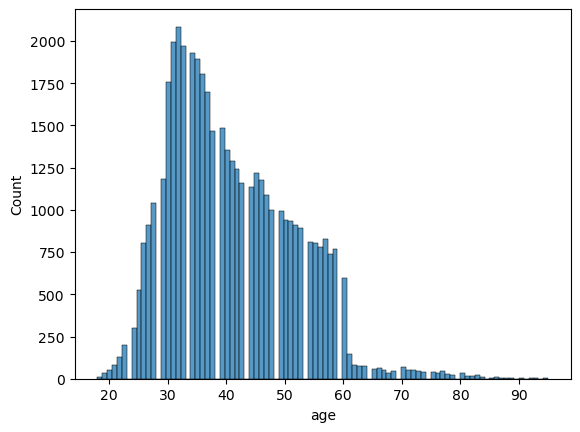

In [51]:
# I think the best predictors for determining if a direct marketing campaign will result in a client subscribing to a term deposit are:
    # Age (older people), job anyone not 'unknown', 'unemployed', 'student', 'retired'), education (tertiary and secondary), doesn't have credit in default, already has a balance with the bank, duration of the call

df_train['age'].describe()
sns.histplot(df_train['age'])

### **Job**

In [52]:
df_train['job'].value_counts(normalize=True) * 100 # getting percentage of each class in variable 'job'

job
blue-collar      21.525735
management       20.919688
technician       16.803433
admin.           11.437482
services          9.188029
retired           5.007631
self-employed     3.492513
entrepreneur      3.289023
unemployed        2.882042
housemaid         2.742695
student           2.074716
unknown           0.637013
Name: proportion, dtype: float64

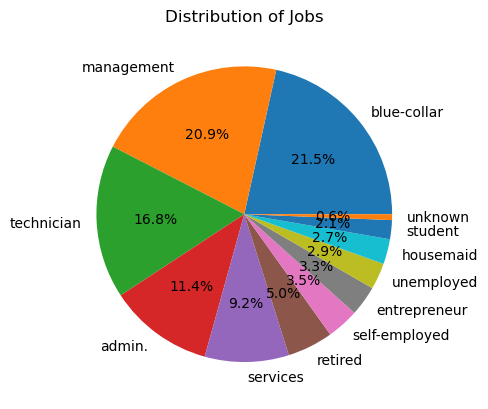

In [53]:
df_train['job'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Jobs')
plt.ylabel('')
plt.show()

### **Education**

In [54]:
df_train['education'].value_counts(normalize=True) * 100

education
secondary    51.319369
tertiary     29.419831
primary      15.153392
unknown       4.107407
Name: proportion, dtype: float64

### **Credit Default**

In [71]:
df_train['default'].value_counts(normalize=True) * 100

default
no     98.197341
yes     1.802659
Name: proportion, dtype: float64

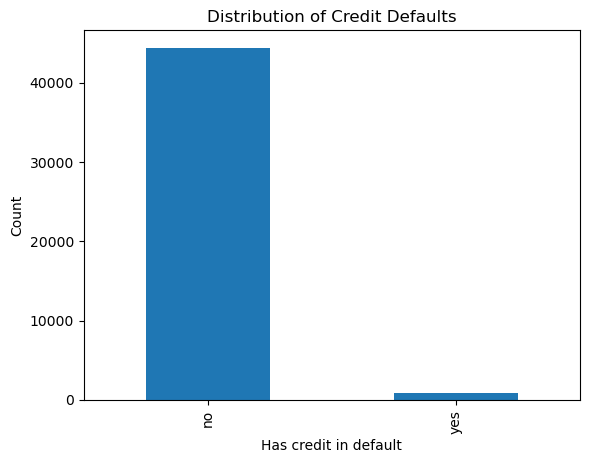

In [55]:
df_train['default'].value_counts().plot(kind='bar')
plt.title('Distribution of Credit Defaults')
plt.xlabel('Has credit in default')
plt.ylabel('Count')
plt.show()

### **Balance**

In [56]:
df_train['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

<Axes: xlabel='balance', ylabel='Count'>

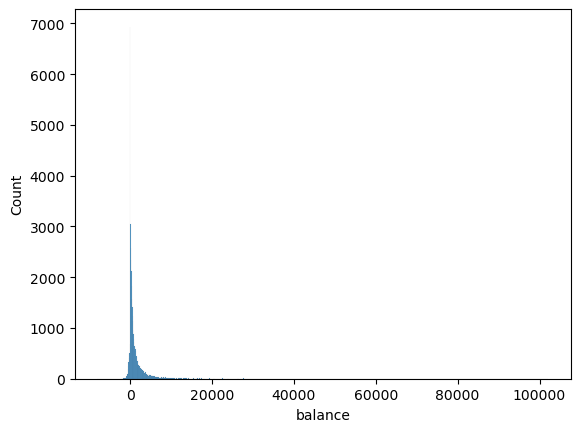

In [ ]:
sns.histplot(df_train['balance']) # there are some unusually high outliers pulling the mean upward
# data is right skewed

In [ ]:
df_train['balance'].mode() # most clients have an average yearly balance of $0 with the bank

0    0
Name: balance, dtype: int64

In [ ]:
print(f"98th percentile: {df_train['balance'].quantile(0.98):,.2f}") # looking at the 98th quantile
# just below $10,000

98th percentile: 9,439.40


In [ ]:
# looking at 99th percentile 
print(f"99th percentile: {df_train['balance'].quantile(0.989):,.2f}") 
# a larger jump, this is a good place to winsorize 

99th percentile: 12,757.01


### **Duration of the Call for the Campaign**

In [58]:
df_train['duration'].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

<Axes: xlabel='duration', ylabel='Count'>

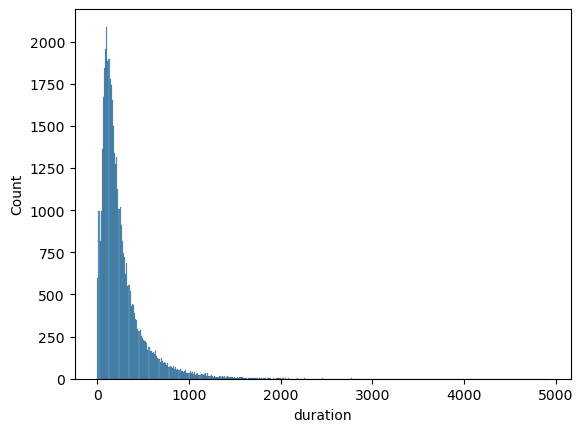

In [59]:
sns.histplot(df_train['duration']) # right skewed
# most people stay on the phone for less than 4 minutes

In [60]:
df_train['duration'].mode() # Most people are on the phone for 2 minutes

0    124
Name: duration, dtype: int64

## **Preparing Data for Linear Model**

**Applying all filters together**
- Keeping clients 35 or older
- Keeping clients who are not retired, students, unemployed, or have an unknown occupation
- Keeping clients with at least secondary education
- Keeping clients who stayed on the phone for at least two minutes (who engaged meaningfully with calls)

## **All Filter Data Set**

In [91]:
age_filter = df_train['age'] >= 35
job_filter = ~df_train['job'].isin(['unknown', 'unemployed', 'student', 'retired'])
education_filter = ~df_train['education'].isin(['unknown', 'primary'])
duration_filter = df_train['duration'] >= 120

combined_filter = age_filter & job_filter & education_filter & duration_filter
df_filtered_train = df_train[combined_filter].copy()

print(f"Retention Rate: {len(df_filtered_train)/len(df_train)*100:.1f}%") # only about 1/3 of the training set remains after all filters are applied

Retention Rate: 31.2%


<Axes: xlabel='balance', ylabel='Count'>

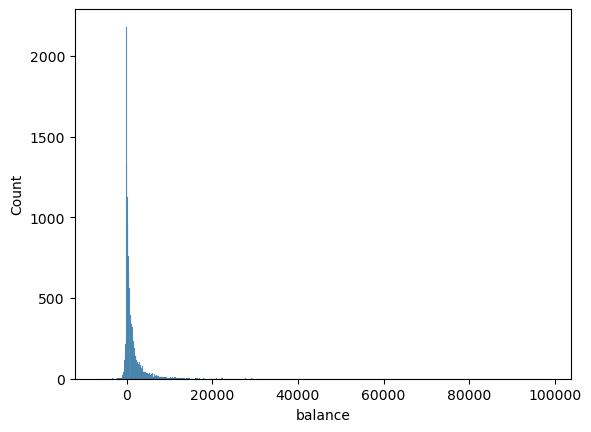

In [94]:
sns.histplot(df_filtered_train['balance'])

<Axes: ylabel='Count'>

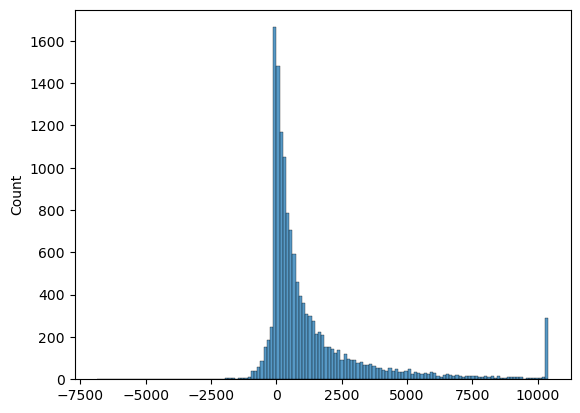

In [98]:
# winsorizing at 98th percentile to get a better look at most clients with the bank
# only winsorizing uppe tail because I think negative balances could be a good indicator for future deposit prediction
from scipy.stats import mstats
balance_winsorized_train = mstats.winsorize(df_filtered_train['balance'], limits=[0, 0.02])
sns.histplot(balance_winsorized_train)

**Feature prep for all filter data set**

In [100]:
df_filtered_train['balance_winsorized'] = mstats.winsorize(df_filtered_train['balance'], limits=[0, 0.02]) # winsorizing balance above 98th percentile

# defining quantitative and qualtitative predictors
numeric_features = ['age', 'balance_winsorized', 'duration'] 
categorical_features = ['job', 'education', 'default']

X_numeric = df_filtered_train[numeric_features]
X_categorical = df_filtered_train[categorical_features]

# one hot encoding categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_categorical_encoded = encoder.fit_transform(X_categorical)

categorical_names = encoder.get_feature_names_out(categorical_features)

X_categorical_df = pd.DataFrame(
    X_categorical_encoded,
    columns=categorical_names,
    index=df_filtered_train.index 
)

In [101]:
# using a linear regression model to assess if the relationship between a client subscribing to more deposits and the data is best described as a linear relationship
import statsmodels.api as sm

X = pd.concat([X_numeric, X_categorical_df], axis=1) # independent variables
y = df_filtered_train['y'] # dependent variable
X = sm.add_constant(X) # adding intercept

lin_model = sm.OLS(y, X).fit()
print(lin_model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     194.8
Date:                Wed, 24 Sep 2025   Prob (F-statistic):               0.00
Time:                        15:13:49   Log-Likelihood:                -4368.1
No. Observations:               14115   AIC:                             8762.
Df Residuals:                   14102   BIC:                             8860.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0657      0

- Low R^2 (0.142) and note from model suggesting strong multicollinearity means I should refine my approach.